In [3]:
import pandas as pd
import pymc as pm
import numpy as np
import arviz as az
import pymc_bart as pmb
import matplotlib.pyplot as plt
import seaborn as sns

# Modelando la superficie de respuesta con pymc-bart

In [25]:
X = pd.read_csv("data/X.csv")
zy = pd.read_csv("data/zy_2.csv") #uso la condicion 2 de las 20 condiciones del concurso. Ground truths en zymu_1.csv

z = zy["z"].values #tratamiento asignado
y = zy["y"].values # observaciones

num_covariates = X.shape[1]
num_individuals = X.shape[0]
print(f"Número de covariables: {num_covariates}")
print(f"Número de individuos: {num_individuals}")

Número de covariables: 58
Número de individuos: 4802


In [23]:
X.dtypes

x_1       int64
x_2      object
x_3     float64
x_4     float64
x_5       int64
x_6       int64
x_7       int64
x_8       int64
x_9       int64
x_10      int64
x_11      int64
x_12      int64
x_13      int64
x_14      int64
x_15      int64
x_16      int64
x_17      int64
x_18      int64
x_19      int64
x_20      int64
x_21     object
x_22      int64
x_23      int64
x_24     object
x_25      int64
x_26      int64
x_27      int64
x_28      int64
x_29      int64
x_30      int64
x_31      int64
x_32      int64
x_33      int64
x_34      int64
x_35      int64
x_36      int64
x_37      int64
x_38      int64
x_39      int64
x_40      int64
x_41      int64
x_42      int64
x_43      int64
x_44      int64
x_45      int64
x_46      int64
x_47      int64
x_48      int64
x_49      int64
x_50      int64
x_51      int64
x_52      int64
x_53      int64
x_54      int64
x_55      int64
x_56      int64
x_57      int64
x_58      int64
dtype: object

Preprocesamiento:

* one-hot encoding de las variables categoricas
* castear valores numericos a float32


In [24]:
X.head()

,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_49,x_50,x_51,x_52,x_53,x_54,x_55,x_56,x_57,x_58
0,29,C,1.0,7.0,60,85,0,0,1,0,...,0,0,0,0,0,0,0,0,45,39
1,27,C,0.0,0.0,64,178,0,0,0,0,...,0,0,0,0,0,0,0,0,46,42
2,27,C,0.0,0.0,60,102,0,0,0,0,...,1,0,0,0,0,0,0,0,45,40
3,37,C,0.0,0.0,65,174,0,0,0,0,...,0,0,0,0,0,0,0,0,47,40
4,24,C,20.0,14.0,63,129,0,0,0,0,...,2,0,0,0,0,0,0,0,47,43


In [18]:
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
categorical_cols

['x_2', 'x_21', 'x_24']

In [20]:
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
X_encoded = X_encoded.astype('float32')
X_encoded.head()

,x_1,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,...,x_21_K,x_21_L,x_21_M,x_21_N,x_21_O,x_21_P,x_24_B,x_24_C,x_24_D,x_24_E
0,29.0,1.0,7.0,60.0,85.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,27.0,0.0,0.0,64.0,178.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,27.0,0.0,0.0,60.0,102.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,37.0,0.0,0.0,65.0,174.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,24.0,20.0,14.0,63.0,129.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Primer intento de modelo:

$$Y_i = f(X_i, Z_i) + \epsilon_i$$

La respuesta $Y_i$ depende una superficie de respuesta desconocida $f$ de las variables $X_i$ y $Z_i$ y un error aleatorio $\epsilon_i$. La superficie de respuesta es modelada con BART.

En principio no tenemos mucha informacion, asumimos que $\epsilon_i$ tiene distribucion normal con media cero y desvio estandard $\sigma$ con distribucion HalfNormal ancha. 

In [35]:
with pm.Model() as model1:
    # covariables + Z
    X_combined = pm.Data('X_combined', X_encoded.assign(treatment=z))
    
    # Define BART model
    mu = pmb.BART('mu', X_combined, Y=y)
    
    # Likelihood
    sigma = pm.HalfNormal('sigma', 3)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

model1

   mu ~ BART(<shared>, <constant>, 50, 0.95, 2)
sigma ~ HalfNormal(0, 3)
y_obs ~ Normal(mu, sigma)

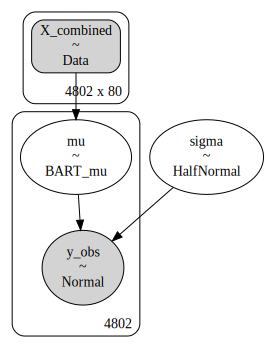

In [36]:
pm.model_to_graphviz(model1)

In [40]:
with model1:
    trace = pm.sample(2000, tune=1000, target_accept=0.95)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>PGBART: [mu]
>NUTS: [sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 57 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


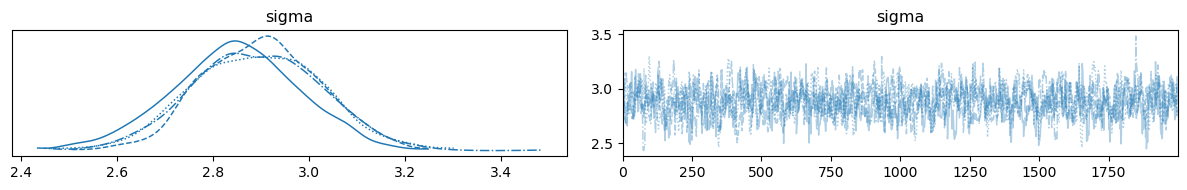

In [41]:
az.plot_trace(trace, var_names=[ "sigma"])
plt.tight_layout()

In [42]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],4.251,0.898,2.648,5.985,0.027,0.016,1085.0,2040.0,1.01
mu[1],6.840,0.994,4.979,8.702,0.030,0.018,1083.0,1869.0,1.01
mu[2],7.527,1.085,5.539,9.598,0.032,0.019,1134.0,2116.0,1.01
mu[3],0.990,1.092,-1.162,2.919,0.032,0.017,1189.0,2333.0,1.00
mu[4],1.396,1.032,-0.461,3.358,0.032,0.016,1053.0,2168.0,1.01
...,...,...,...,...,...,...,...,...,...
mu[4798],7.845,1.100,5.878,9.999,0.034,0.018,1056.0,2047.0,1.00
mu[4799],7.306,1.036,5.399,9.272,0.031,0.018,1138.0,1976.0,1.00
mu[4800],5.247,1.050,3.270,7.242,0.031,0.017,1127.0,2258.0,1.01
mu[4801],2.741,0.989,0.898,4.569,0.030,0.017,1122.0,2104.0,1.00


In [43]:
# Sampleo posterior predictivo, para predecir la media de las respuestas (la observada y la contrafactual)
# Sampleo ambos Z=1 y Z=0 en diferentes variables. Asigno Z=1 a tratamiento y Z=0 a control, dado el contexto del problema da igual la eleccion creo.

with model1:
    
    X_treated = pm.set_data({'X_combined': X_encoded.assign(treatment=1.0)})
    mu_treated = pm.sample_posterior_predictive(trace, var_names=["mu"])

    X_control = pm.set_data({'X_combined': X_encoded.assign(treatment=0.0)})
    mu_control = pm.sample_posterior_predictive(trace, var_names=["mu"])

Sampling: [mu]


Output()

Sampling: [mu]


Output()

In [68]:
pp_mu_treated = az.extract(mu_treated.posterior_predictive)
pp_mu_control = az.extract(mu_control.posterior_predictive)


In [74]:
# Efecto del tratamiento individual (ITE)
ite_samples = pp_mu_treated - pp_mu_control 

# Promedio sobre los individuos (ATE)
ate_samples = ite_samples.mean(dim="mu_dim_0")

In [87]:
ate_samples

<xarray.Dataset> Size: 192kB
Dimensions:  (sample: 8000)
Coordinates:
  * sample   (sample) object 64kB MultiIndex
  * chain    (sample) int32 32kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int32 32kB 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
Data variables:
    mu       (sample) float64 64kB 0.3319 0.6489 0.8458 ... 1.407 1.538 3.099

Text(0.5, 0, 'ATE')

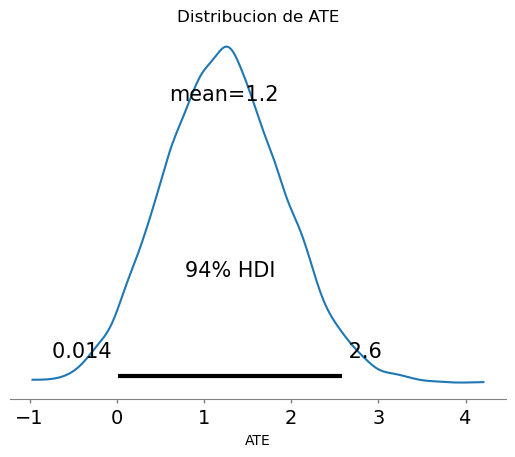

In [115]:
az.plot_posterior(ate_samples["mu"].values)
plt.title("Distribucion de ATE")
plt.xlabel("ATE")